## MOUNT

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---

## IMPORTS

In [3]:
import os
import pickle
# import warnings
# warnings.filterwarnings('ignore')

In [4]:
from IPython.display import display, display_html

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sns.set()
%config InlineBackend.figure_format = 'retina'

In [6]:
from scipy.sparse import csr_matrix, hstack

In [ ]:
# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, HashingVectorizer

# training - evaluating
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_predict, TimeSeriesSplit

# logit features
!pip install eli5
import eli5

---

## CONSTANTS

In [11]:
# path to data
PATH_TO_TRAIN = "drive/MyDrive/Projects/Alice/data/train_sessions.csv"
PATH_TO_TEST = "drive/MyDrive/Projects/Alice/data/test_sessions.csv"
PATH_TO_DICT = "drive/MyDrive/Projects/Alice/data/site_dic.pkl"
PATH_TO_SUBM = "drive/MyDrive/Projects/Alice/submissions/"

In [12]:
# parameters - hyper parameters
SEED = 17
N_JOBS = 4
NUM_TIME_SPLITS = 10    # for time-based cross-validation
SITE_NGRAMS = (1, 5)    # site ngrams for "bag of sites"
MAX_FEATURES = 50000    # max features for "bag of sites"
BEST_LOGIT_C = 8.8586   # precomputed tuned C for logistic regression
TIME_SPLIT = TimeSeriesSplit(n_splits=NUM_TIME_SPLITS)
SCORING = "roc_auc"
LOGIT = LogisticRegression(C=1, random_state=SEED, solver='liblinear')

In [13]:
# convenient column selection
TIMES = ["time%s" % t for t in range(1,11)]
SITES = ["site%s" % s for s in range(1,11)]

---

## READING FILES

In [14]:
train_df = pd.read_csv(PATH_TO_TRAIN)
test_df = pd.read_csv(PATH_TO_TEST)

In [15]:
print("TRAIN SET")
display(train_df.head(2))

print("TEST SET")
display(test_df.head(2))

TRAIN SET


,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
0,1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,3846.0,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0


TEST SET


,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
0,1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
1,2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53


---

## BASIC INFO

In [16]:
# will be using time split cross validation
# time must be storted 
train_df = train_df.sort_values(by="time1")

In [17]:
train_df.info()
# Main observations:
# 1. change object to datetime format
# 2. change sites nulls to 0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 21668 to 204761
Data columns (total 22 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   session_id  253561 non-null  int64  
 1   site1       253561 non-null  int64  
 2   time1       253561 non-null  object 
 3   site2       250098 non-null  float64
 4   time2       250098 non-null  object 
 5   site3       246919 non-null  float64
 6   time3       246919 non-null  object 
 7   site4       244321 non-null  float64
 8   time4       244321 non-null  object 
 9   site5       241829 non-null  float64
 10  time5       241829 non-null  object 
 11  site6       239495 non-null  float64
 12  time6       239495 non-null  object 
 13  site7       237297 non-null  float64
 14  time7       237297 non-null  object 
 15  site8       235224 non-null  float64
 16  time8       235224 non-null  object 
 17  site9       233084 non-null  float64
 18  time9       233084 non-null  object 
 19

In [18]:
test_df.info()
# same changes need to be applied as to train_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82797 entries, 0 to 82796
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   session_id  82797 non-null  int64  
 1   site1       82797 non-null  int64  
 2   time1       82797 non-null  object 
 3   site2       81308 non-null  float64
 4   time2       81308 non-null  object 
 5   site3       80075 non-null  float64
 6   time3       80075 non-null  object 
 7   site4       79182 non-null  float64
 8   time4       79182 non-null  object 
 9   site5       78341 non-null  float64
 10  time5       78341 non-null  object 
 11  site6       77566 non-null  float64
 12  time6       77566 non-null  object 
 13  site7       76840 non-null  float64
 14  time7       76840 non-null  object 
 15  site8       76151 non-null  float64
 16  time8       76151 non-null  object 
 17  site9       75484 non-null  float64
 18  time9       75484 non-null  object 
 19  site10      74806 non-nul

In [19]:
# some of the operations will made on both train_df and test_df
# instead of hard copying, concatenate them into one single full_df
# this full_df can also be used in exploratory data analysis

# save target from train_df
train_target = train_df['target']

full_df = pd.concat([train_df.drop('target', axis=1), test_df]).copy()

# index to split train_df from test_df
idx_split = train_df.shape[0]

In [20]:
# 1. changing object to datetime
full_df[TIMES] = full_df[TIMES].apply(pd.to_datetime)

In [21]:
# 2. changing sites' nulls to 0
full_df[SITES] = full_df[SITES].fillna(0).astype("int")
# now can work with the given data

In [22]:
# updating train_df and test_df
train_df = full_df[:idx_split]
test_df = full_df[idx_split:]

In [ ]:
# returning target column
train_df["target"] = train_target

In [24]:
full_df.head(2)

,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
21668,21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
54842,54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT


In [25]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336358 entries, 21668 to 82796
Data columns (total 21 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   session_id  336358 non-null  int64         
 1   site1       336358 non-null  int64         
 2   time1       336358 non-null  datetime64[ns]
 3   site2       336358 non-null  int64         
 4   time2       331406 non-null  datetime64[ns]
 5   site3       336358 non-null  int64         
 6   time3       326994 non-null  datetime64[ns]
 7   site4       336358 non-null  int64         
 8   time4       323503 non-null  datetime64[ns]
 9   site5       336358 non-null  int64         
 10  time5       320170 non-null  datetime64[ns]
 11  site6       336358 non-null  int64         
 12  time6       317061 non-null  datetime64[ns]
 13  site7       336358 non-null  int64         
 14  time7       314137 non-null  datetime64[ns]
 15  site8       336358 non-null  int64         
 16 

---

## EDA

### main observations

In [26]:
train_df[TIMES].head(4)

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
21668,2013-01-12 08:05:57,2013-01-12 08:05:57,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
54842,2013-01-12 08:37:23,2013-01-12 08:37:23,2013-01-12 09:07:07,2013-01-12 09:07:09,NaT,NaT,NaT,NaT,NaT,NaT
77291,2013-01-12 08:50:13,2013-01-12 08:50:14,2013-01-12 08:50:15,2013-01-12 08:50:15,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:17,2013-01-12 08:50:17
114020,2013-01-12 08:50:17,2013-01-12 08:50:17,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:18,2013-01-12 08:50:19,2013-01-12 08:50:19,2013-01-12 08:50:19,2013-01-12 08:50:20


will be observing:

- start hour.
- end hour.
- daily,
- weekly,
- monthly observations.
- session length.
- time differences.
- most visited web sites.


---

### checking target balance

In [27]:
train_df[train_df["target"] == 1].shape, train_df[train_df["target"] == 0].shape

# the data is imbalanced, 2297 Alice samples, 251264 itruders' samples
# can't use accuracy score, will be using ROC AUC for checking the model's performance 

((2297, 22), (251264, 22))

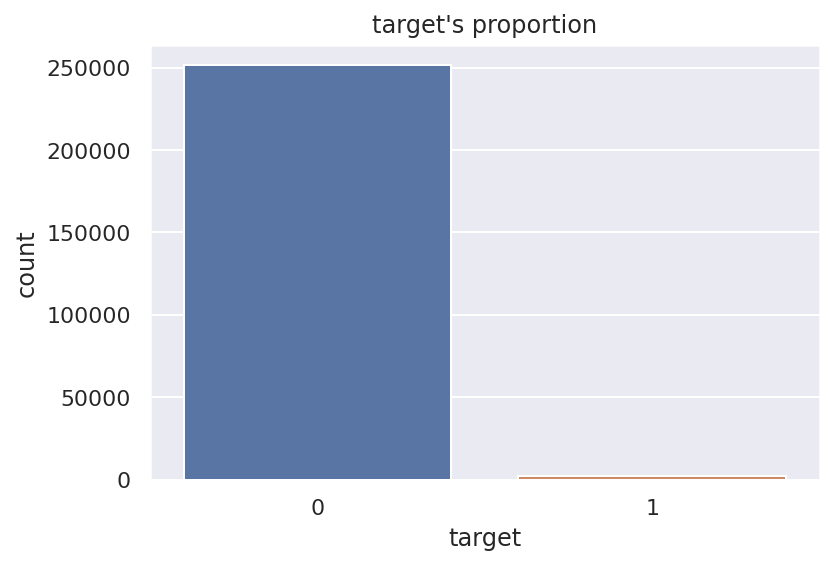

In [28]:
# obesrving it visually
sns.countplot(x = train_df["target"]);
plt.title("target's proportion");

---

### reusable functions for visualization

In [29]:
def two_count_plots(x1, x2, title1, title2):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (17,7))

    sns.countplot(x = x1, ax = ax1);
    sns.countplot(x = x2, ax = ax2);

    ax1.set_title(title1);
    ax2.set_title(title2);


def two_hist_plots(x1, x2, title1, title2, bins = 30):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (17,7))

    sns.histplot(x = x1, ax = ax1, bins = bins);
    sns.histplot(x = x2, ax = ax2, bins = bins);

    ax1.set_title(title1);
    ax2.set_title(title2);

---

### start hour

In [30]:
# checking whether Alice's start hour is different

# creating an additonal DataFrame for new features based on 'train_df'
train_feat = pd.DataFrame(index = train_df.index)
train_feat["target"] = train_df["target"]
# 'time1' column can be used as start hour
train_feat["start_hour"] = train_df["time1"].apply(lambda ts: ts.hour)
train_feat.head()

,target,start_hour
21668,0,8
54842,0,8
77291,0,8
114020,0,8
146669,0,8


In [31]:
# Alice's start hour (average) 
print(train_feat[train_feat["target"] == 1]["start_hour"].mean())

# Intruders' start hour (average)
print(train_feat[train_feat["target"] == 0]["start_hour"].mean())

15.433609055289509
12.259730801069791


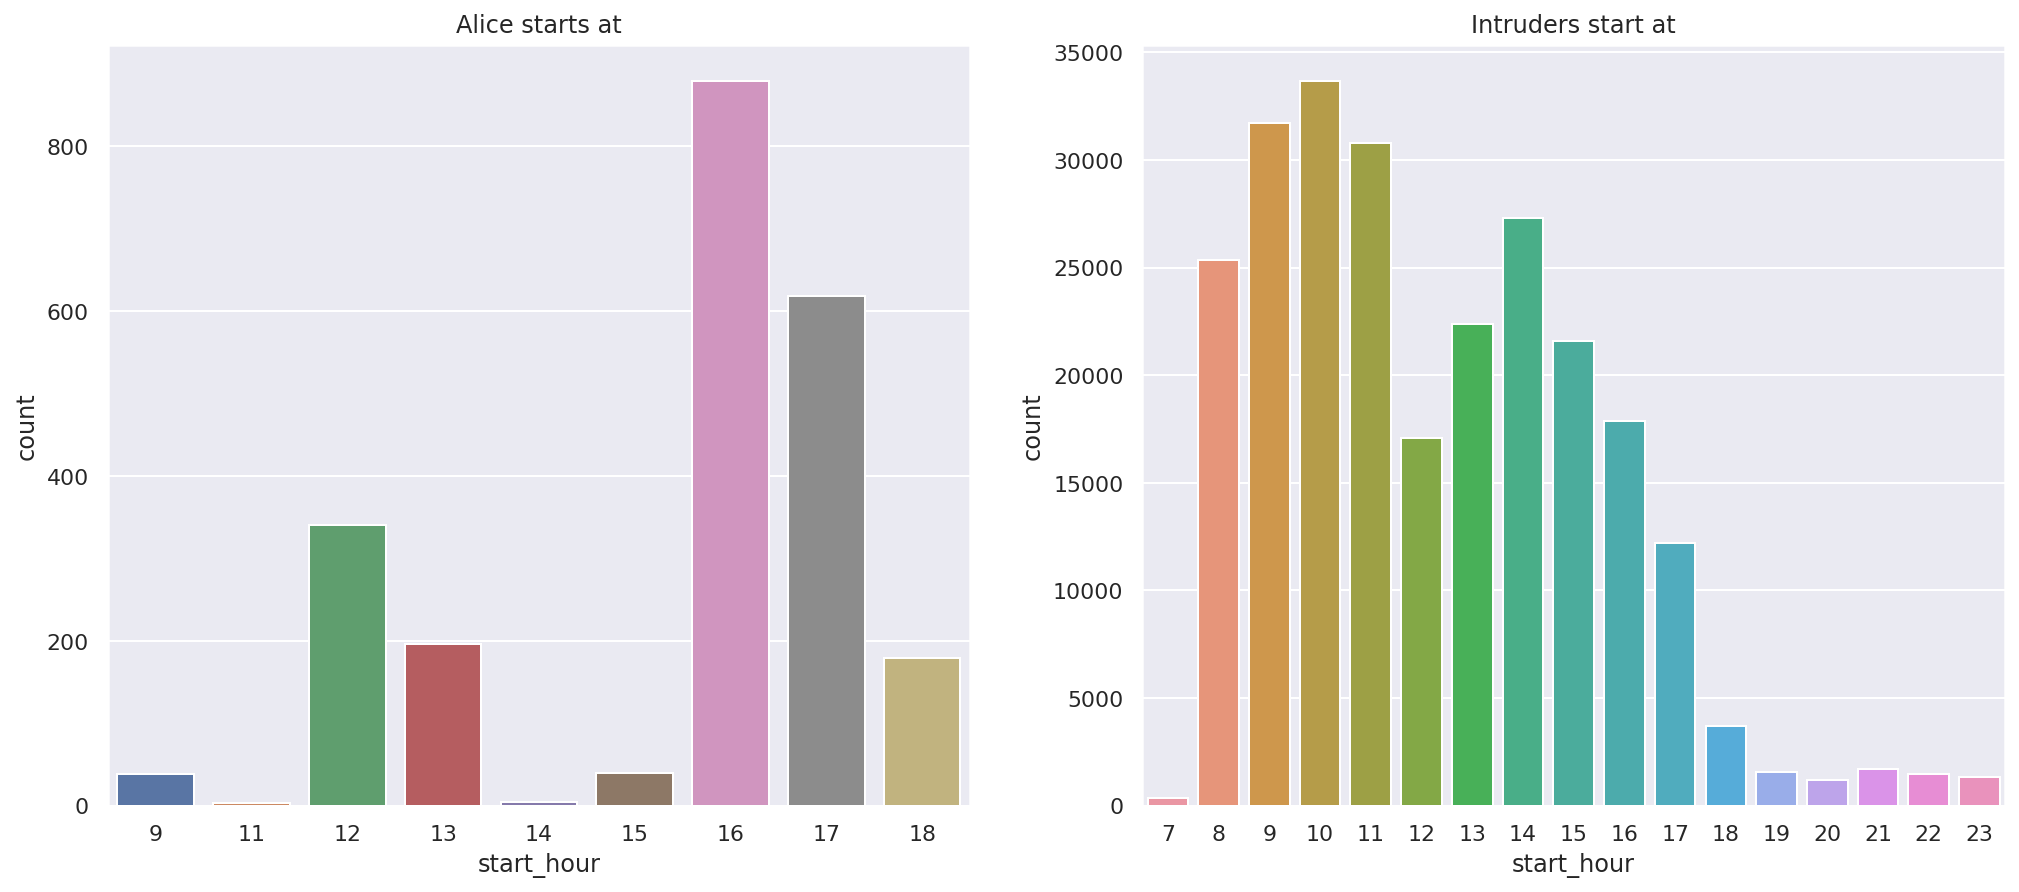

In [32]:
# there is the difference in start hours
# visualizing it
two_count_plots(x1 = train_feat[train_feat["target"] == 1]["start_hour"],
                x2 = train_feat[train_feat["target"] == 0]["start_hour"],
                title1 = "Alice starts at",
                title2 = "Intruders start at")

Alice starts her work at some specific hours (12-13, 16-18 mostly).   
Useful feature. 

---

### end hour

In [33]:
# checking whether Alice's end hour is different

# can't just use 'time10' column as end hour, 
# some of the sessions have less than 10 websites visited

def add_end_hour_column(df, feat):
    end_hour = []

    for row in df[TIMES].values:
        col = len(row) - 1
        while pd.isnull(row[col]):
            col -= 1
        end_hour.append(row[col])

    feat["end_hour"] = end_hour
    feat["end_hour"] = feat["end_hour"].apply(lambda ts: ts.hour)
    
    return feat

In [34]:
train_feat = add_end_hour_column(train_df, train_feat)
train_feat.head()

,target,start_hour,end_hour
21668,0,8,8
54842,0,8,9
77291,0,8,8
114020,0,8,8
146669,0,8,8


In [35]:
# checking the difference
print(train_feat[train_feat["target"] == 1]['end_hour'].mean())

print(train_feat[train_feat["target"] == 0]['end_hour'].mean())
# there is a difference in end hours as well, they are almost equal to start hours.
# it's clear why, the sessions are <30 mins long.

15.451458424031346
12.295963607997962


---

### daily observations

In [36]:
# checking Alice's week day activity.
train_feat["week_day"] = train_df["time1"].dt.dayofweek
# train_feat = train_feat.sort_values(by = "week_day", ascending = True)
train_feat.head()

,target,start_hour,end_hour,week_day
21668,0,8,8,5
54842,0,8,9,5
77291,0,8,8,5
114020,0,8,8,5
146669,0,8,8,5


In [37]:
# int to string mapping
week_days = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday",
             4: "Friday", 5: "Saturday", 6: "Sunday"}

train_feat["week_day"] = train_feat["week_day"].map(week_days)

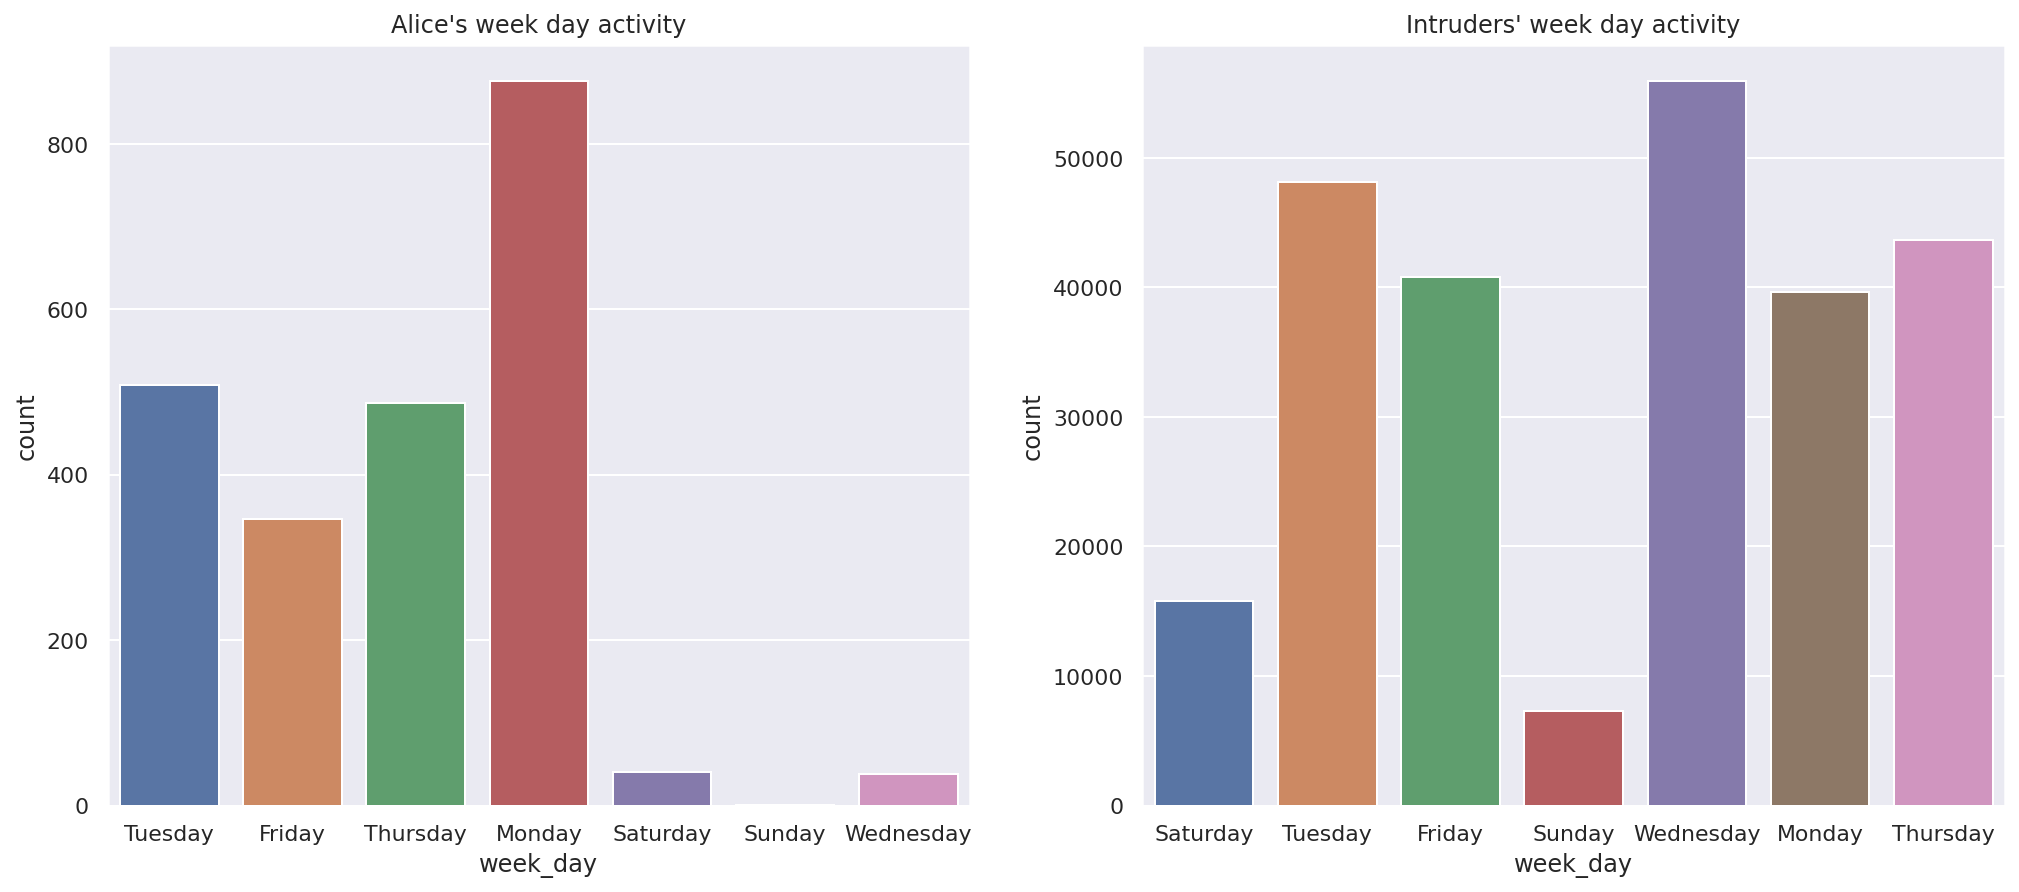

In [38]:
two_count_plots(x1 = train_feat[train_feat["target"] == 1]["week_day"],
                x2 = train_feat[train_feat["target"] == 0]["week_day"],
                title1 = "Alice's week day activity",
                title2 = "Intruders' week day activity")

Alice is most active on Monday. Also Tuesday, Thursday and Friday.
Useful feature.

---

### weekly observations

In [39]:
# adding 'start_session' column 
train_feat["session_start"] = train_df[TIMES].min(axis = 1)
train_feat.head()

,target,start_hour,end_hour,week_day,session_start
21668,0,8,8,Saturday,2013-01-12 08:05:57
54842,0,8,9,Saturday,2013-01-12 08:37:23
77291,0,8,8,Saturday,2013-01-12 08:50:13
114020,0,8,8,Saturday,2013-01-12 08:50:17
146669,0,8,8,Saturday,2013-01-12 08:50:20


In [40]:
train_feat["session_start"].min(), train_feat["session_start"].max() 
# the difference between the first and last sessions is ~60 weeks

(Timestamp('2013-01-12 08:05:57'), Timestamp('2014-04-30 23:39:53'))

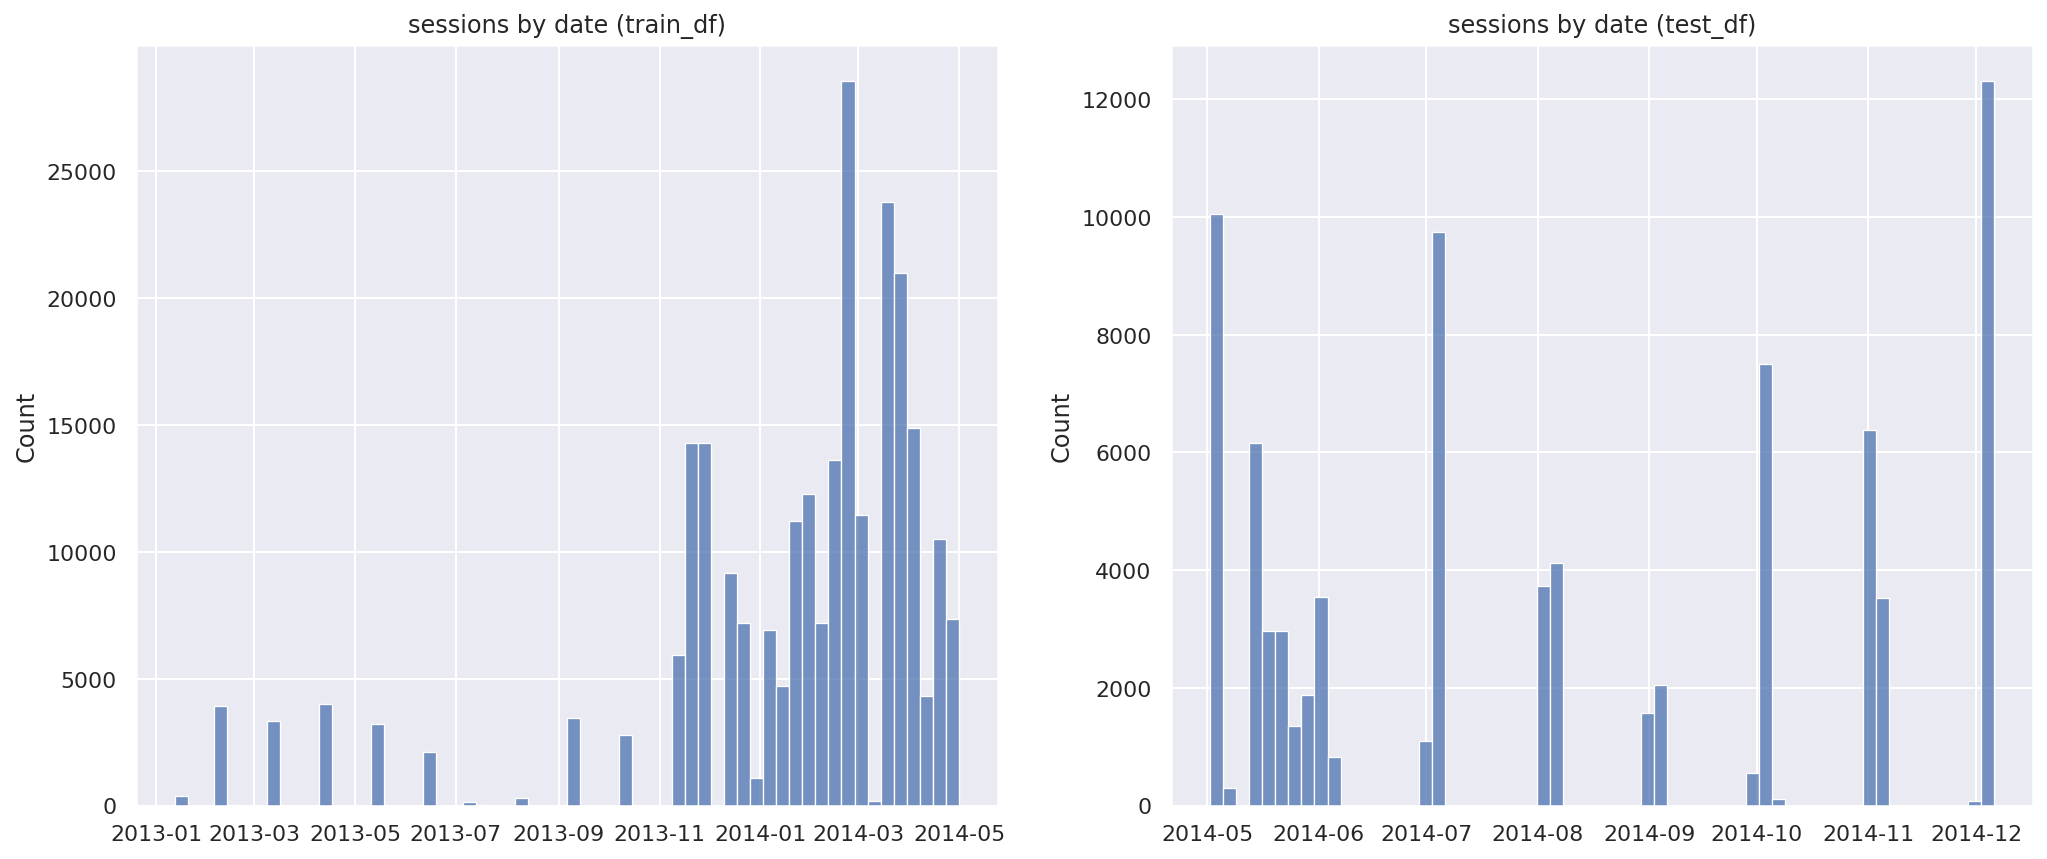

In [41]:
two_hist_plots(x1 = train_df[TIMES].min(axis = 1), 
               x2 = test_df[TIMES].min(axis = 1),
               title1 = "sessions by date (train_df)",
               title2 = "sessions by date (test_df)",
               bins=60)

Above: The train and test sessions by date aren't equally ditributed. Predictions may not be accurate.  
Below: The difference of Alice's and Intruders' sessions by date are different.  
May be useful feature.

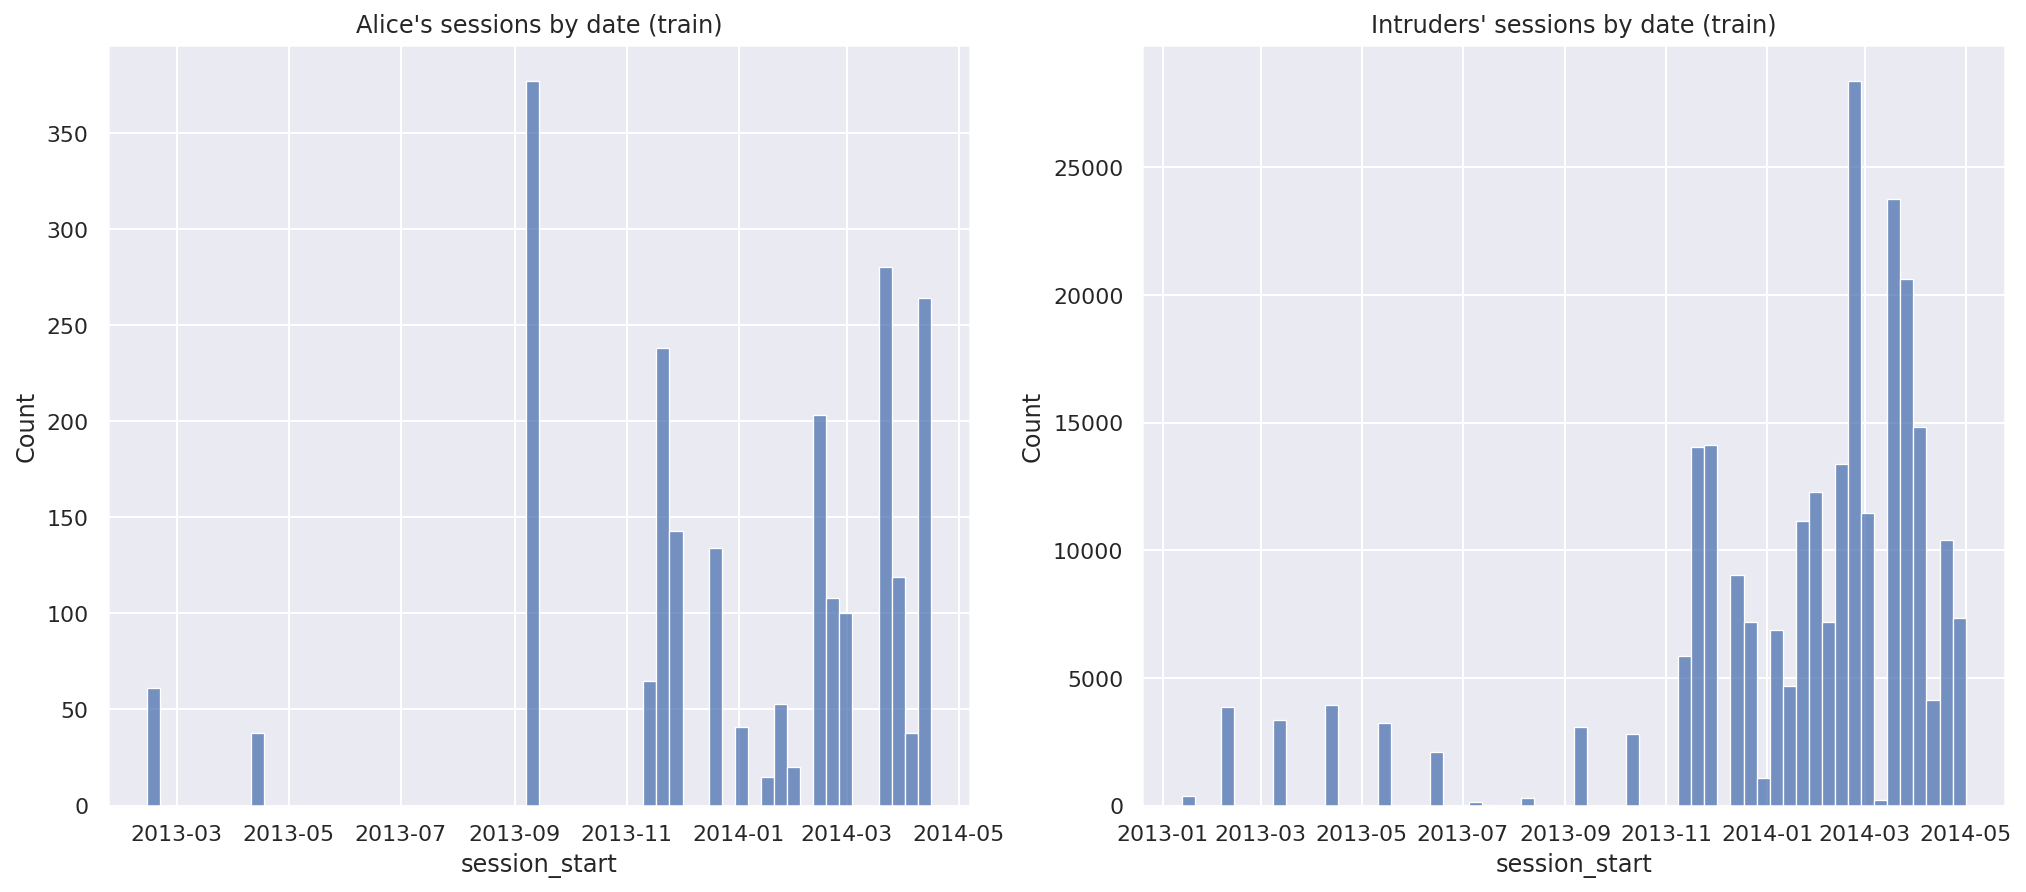

In [42]:
two_hist_plots(x1 = train_feat[train_feat["target"] == 1]["session_start"],
               x2 = train_feat[train_feat["target"] == 0]["session_start"],
               title1 = "Alice's sessions by date (train)",
               title2 = "Intruders' sessions by date (train)",
               bins=60)

---

### monthly observations

In [43]:
# adding 'month' column 
train_feat["month"] = train_feat["session_start"].apply(lambda ts: ts.month)

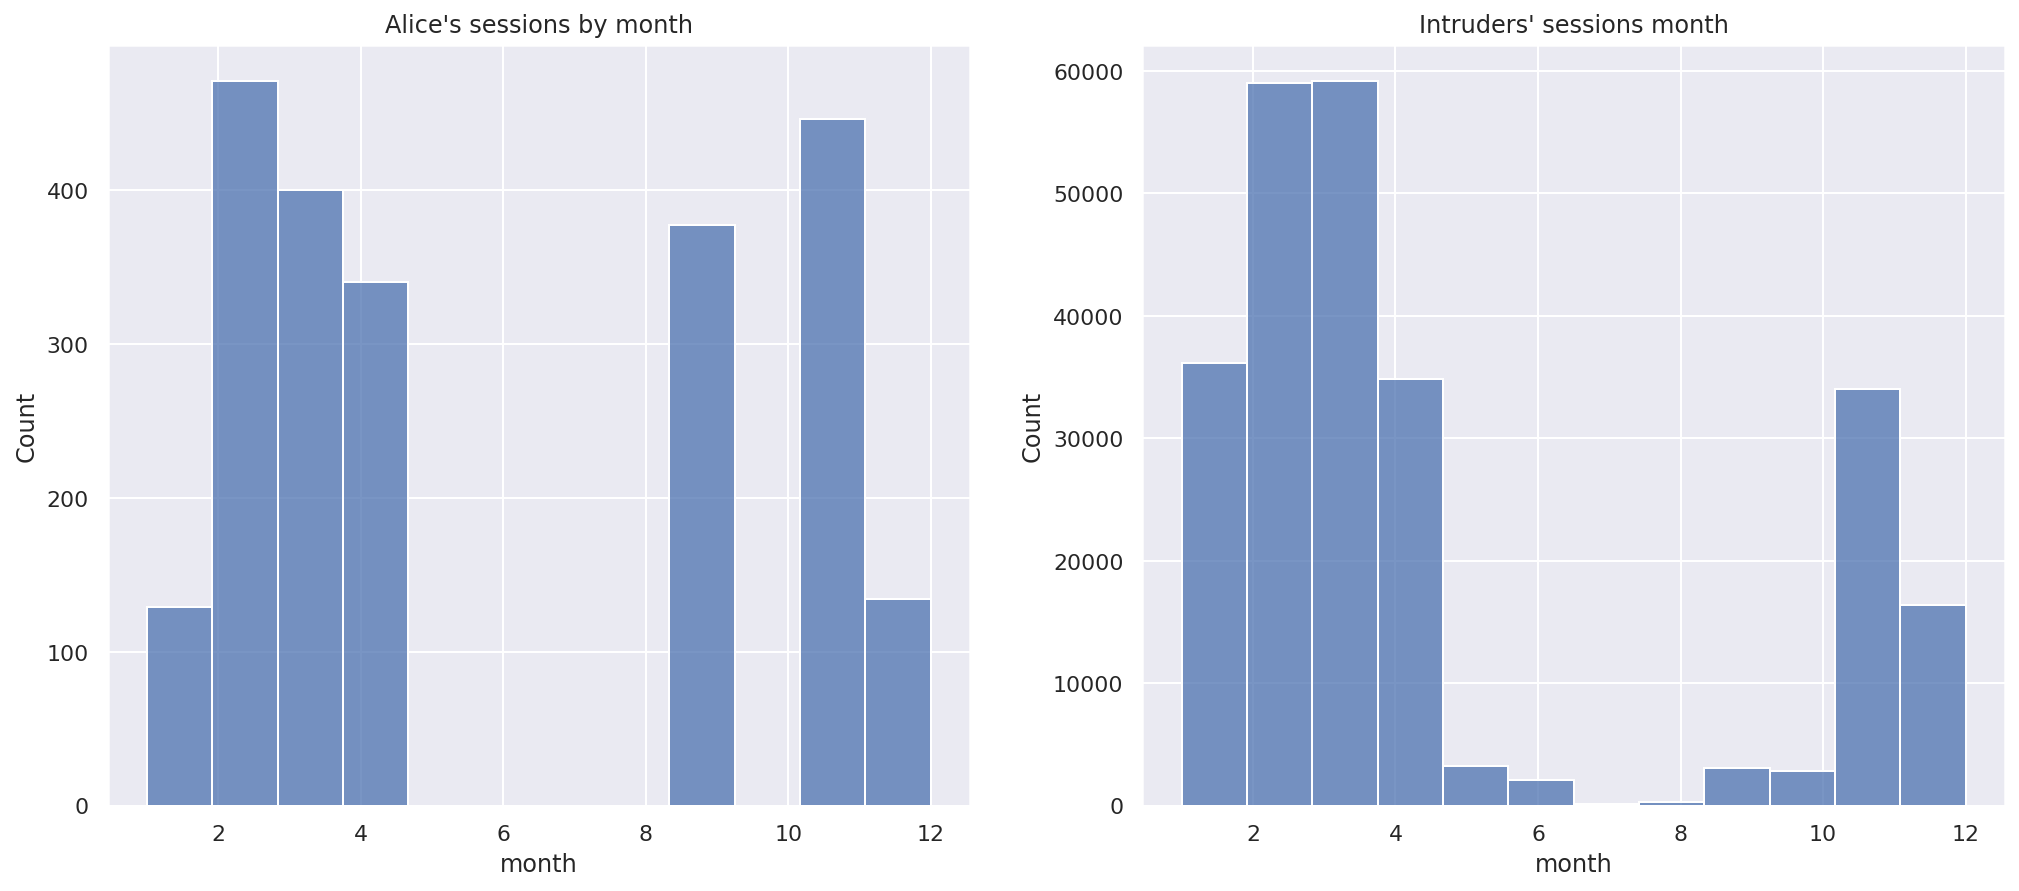

In [44]:
two_hist_plots(x1 = train_feat[train_feat["target"] == 1]["month"],
               x2 = train_feat[train_feat["target"] == 0]["month"],
               title1 = "Alice's sessions by month",
               title2 = "Intruders' sessions month",
               bins = 12)

- Above: Alice is active in February-April, September and November.  
Intruders are active in January-April, November and December.  
Plots differ a bit.

- Below: train and test sessions by month aren't ditributed equally.  
Can't make any assumptions.

Feature doesn't seem to be useful.  
It's not time series, hence months may not be relevant.



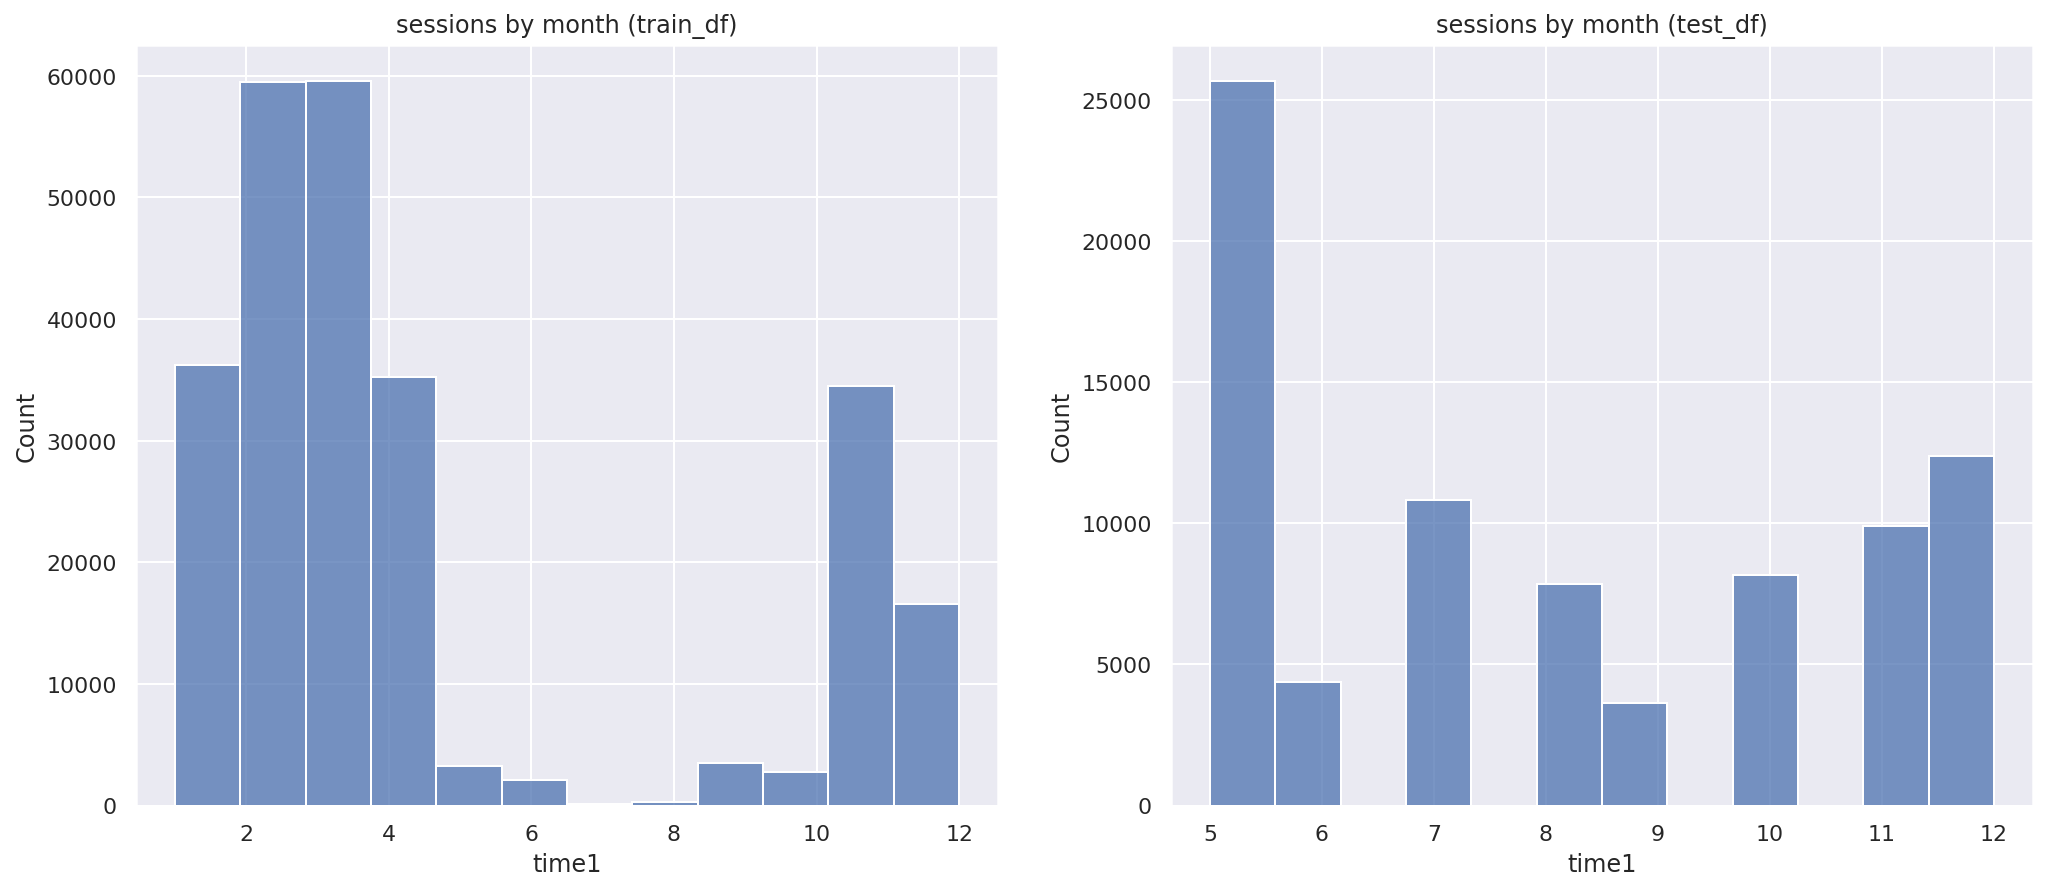

In [45]:
two_hist_plots(x1 = train_df["time1"].apply(lambda ts: ts.month), 
               x2 = test_df["time1"].apply(lambda ts: ts.month),
               title1 = "sessions by month (train_df)",
               title2 = "sessions by month (test_df)",
               bins = 12)

---

### session duration

In [46]:
# adding 'session_length' column 
train_feat["session_length"] = ( train_df[TIMES].max(axis = 1) \
                                - train_df[TIMES].min(axis = 1) 
                               ).dt.seconds

In [47]:
train_feat.head()

,target,start_hour,end_hour,week_day,session_start,month,session_length
21668,0,8,8,Saturday,2013-01-12 08:05:57,1,0
54842,0,8,9,Saturday,2013-01-12 08:37:23,1,1786
77291,0,8,8,Saturday,2013-01-12 08:50:13,1,4
114020,0,8,8,Saturday,2013-01-12 08:50:17,1,3
146669,0,8,8,Saturday,2013-01-12 08:50:20,1,2


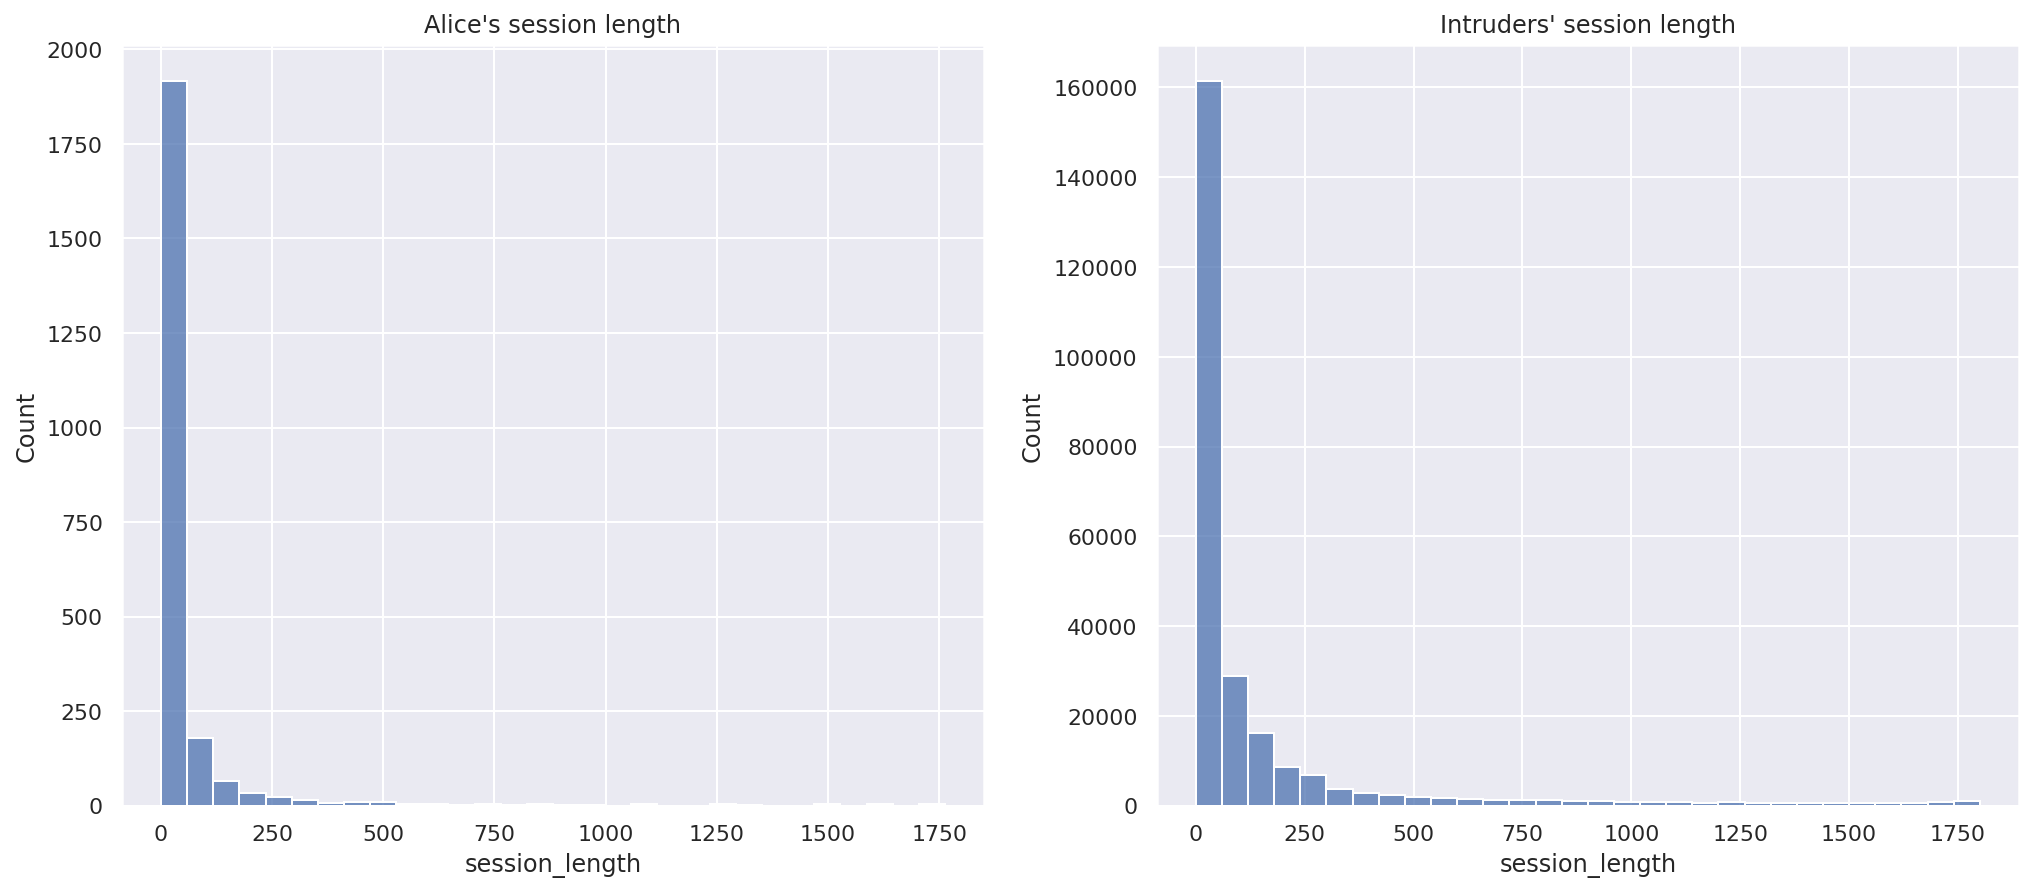

In [48]:
# Checking whether Alice's sessions' lengths differ.
two_hist_plots(x1 = train_feat[train_feat["target"] == 1]["session_length"],
               x2 = train_feat[train_feat["target"] == 0]["session_length"],
               title1 = "Alice's session length",
               title2 = "Intruders' session length")

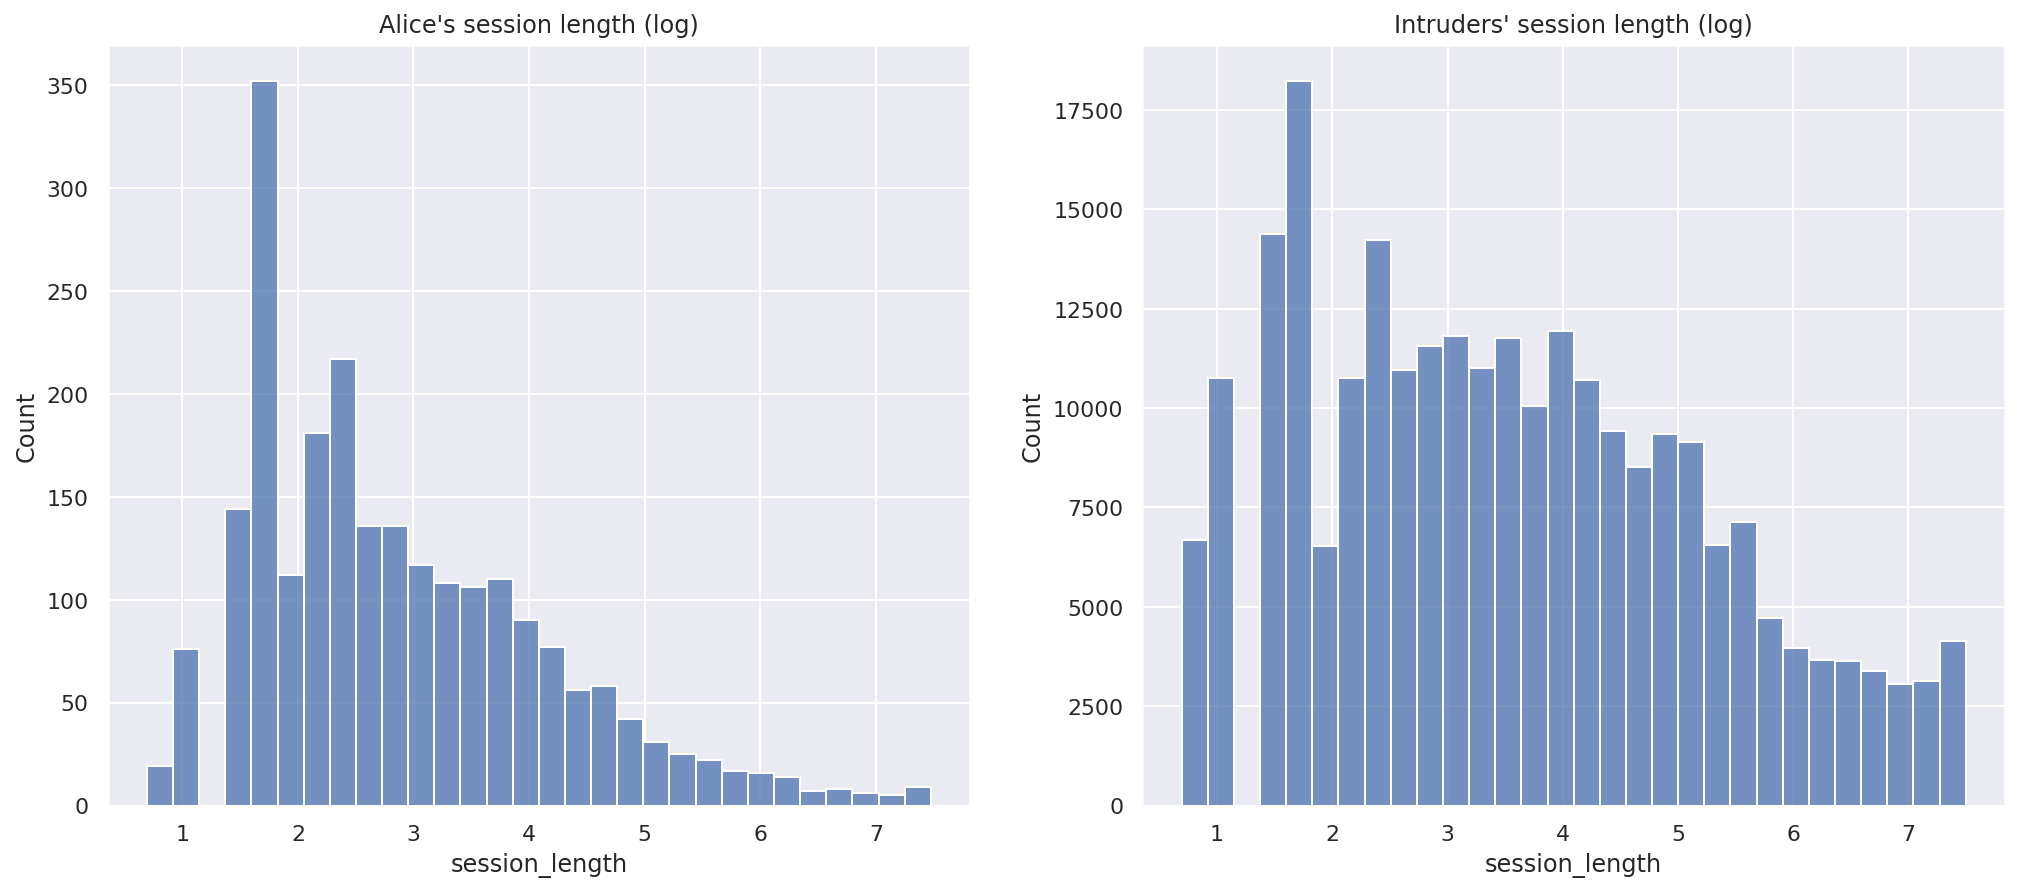

In [49]:
# Not giving much information, wrapping it into logartihm.
two_hist_plots(x1 = np.log1p(train_feat[train_feat["target"] == 1]["session_length"] + 1),
               x2 = np.log1p(train_feat[train_feat["target"] == 0]["session_length"] + 1),
               title1 = "Alice's session length (log)",
               title2 = "Intruders' session length (log)")

There's a difference, but not crucial.  
Feature may be useful.

---

### time differences in seconds

In [50]:
# time difference between each time in TIMES
# time2 - time1, time3 - time2, time4 - time3, etc., until timeX is null.

# adding 'time_diff[1-9]' columns
def get_time_diff(row):
    row_len = row.shape[0] - 1 
    t_diff = [0] * row_len
    t = 0 
    while (t < row_len) and pd.notnull(row[t + 1]): 
        t_diff[t] = (row[t + 1] - row[t]) / np.timedelta64(1,'s') 
        t += 1 
    return t_diff


def add_time_diff_columns(df, feat):
    # applying for each instance in train_df
    time_diff = []

    for row in df[TIMES].values:
        time_diff.append(get_time_diff(row))
    time_diff = np.log1p(np.array(time_diff).astype(float))
    
    # adding these 9 new columns in train_feat DataFrame
    time_diff_columns = ['time_diff_' + str(t) for t in range(1,10)] 

    for ind, diff_column in enumerate(time_diff_columns): 
        feat[diff_column] = time_diff[:, ind]
        
    return feat

In [51]:
%%time
# adding time differences features
train_feat = add_time_diff_columns(train_df, train_feat)

CPU times: user 18 s, sys: 167 ms, total: 18.2 s
Wall time: 18.2 s


In [52]:
train_feat.head(4)

,target,start_hour,end_hour,week_day,session_start,month,session_length,time_diff_1,time_diff_2,time_diff_3,time_diff_4,time_diff_5,time_diff_6,time_diff_7,time_diff_8,time_diff_9
21668,0,8,8,Saturday,2013-01-12 08:05:57,1,0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
54842,0,8,9,Saturday,2013-01-12 08:37:23,1,1786,0.000000,7.487174,1.098612,0.000000,0.0,0.000000,0.0,0.000000,0.000000
77291,0,8,8,Saturday,2013-01-12 08:50:13,1,4,0.693147,0.693147,0.000000,0.693147,0.0,0.000000,0.0,0.693147,0.000000
114020,0,8,8,Saturday,2013-01-12 08:50:17,1,3,0.000000,0.693147,0.000000,0.000000,0.0,0.693147,0.0,0.000000,0.693147


---

### most visited web sites

In [53]:
train_df[SITES].head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
21668,56,55,0,0,0,0,0,0,0,0
54842,56,55,56,55,0,0,0,0,0,0
77291,946,946,951,946,946,945,948,784,949,946
114020,945,948,949,948,945,946,947,945,946,946
146669,947,950,948,947,950,952,946,951,946,947


In [54]:
# Load websites dictionary
with open(PATH_TO_DICT, "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(
    list(site_dict.keys()), index=list(site_dict.values()), columns=["site"]
)

In [55]:
print(u"Websites total:", sites_dict.shape[0])
sites_dict.head()

Websites total: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


In [56]:
# defining a function for reusability
def get_top_sites(train_sites):
    top_sites = (
        pd.Series(train_sites.values.flatten())
        .value_counts()
        .sort_values(ascending=False)
        .head()
    )
    return top_sites

In [57]:
# most visited websites by all
top_sites = get_top_sites(train_df[SITES])
# print(top_sites)
sites_dict.loc[top_sites.drop(0).index]

,site
21,www.google.fr
23,www.google.com
782,annotathon.org
22,apis.google.com


In [58]:
# most visited websites by Alice
top_sites_alice = get_top_sites(train_df[train_df.target == 1][SITES])
# print(top_sites_alice)
sites_dict.loc[top_sites_alice.index]
# First three -- youtube

,site
77,i1.ytimg.com
80,s.youtube.com
76,www.youtube.com
29,www.facebook.com
21,www.google.fr


---

## DATA PREPROCESSING

### functions for preparing features

In [59]:
train_feat.head()

,target,start_hour,end_hour,week_day,session_start,month,session_length,time_diff_1,time_diff_2,time_diff_3,time_diff_4,time_diff_5,time_diff_6,time_diff_7,time_diff_8,time_diff_9
21668,0,8,8,Saturday,2013-01-12 08:05:57,1,0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
54842,0,8,9,Saturday,2013-01-12 08:37:23,1,1786,0.000000,7.487174,1.098612,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
77291,0,8,8,Saturday,2013-01-12 08:50:13,1,4,0.693147,0.693147,0.000000,0.693147,0.0,0.000000,0.000000,0.693147,0.000000
114020,0,8,8,Saturday,2013-01-12 08:50:17,1,3,0.000000,0.693147,0.000000,0.000000,0.0,0.693147,0.000000,0.000000,0.693147
146669,0,8,8,Saturday,2013-01-12 08:50:20,1,2,0.000000,0.000000,0.693147,0.000000,0.0,0.000000,0.693147,0.000000,0.000000


In [60]:
# "Bag of words" using TF-IDF technique
def add_sparse_features(train_df, test_df, vect_params):
  
  with open(PATH_TO_DICT, 'rb') as f:
    site2id = pickle.load(f)
  # create an inverse id _> site mapping
  id2site = {v:k for (k, v) in site2id.items()}
  # id 0 as "unknown"
  id2site[0] = 'unknown'

  # STEP 3
  # preparing data for TfidVectorizer
  train_sites = train_df[SITES].apply(lambda row: ' '.join([id2site[i] for i in row]), 
                                      axis=1).tolist()
  test_sites = test_df[SITES].apply(lambda row: ' '.join([id2site[i] for i in row]), 
                                    axis=1).tolist()                                   

  # tf_idf vectorizing
  vect = TfidfVectorizer(**vect_params)
  X_train_sparse = vect.fit_transform(train_sites)
  X_test_sparse = vect.transform(test_sites)

  return X_train_sparse, X_test_sparse, vect

In [119]:
# all the features can be added at once in a single function
# but instead they'll be added and tested one by one
# hence separate functions are needed

# 1. start hour
def add_start_hour(df, feat):
  feat["start_hour"] = df["time1"].apply(lambda ts: ts.hour)
  feat = pd.get_dummies(feat, columns=["start_hour"], prefix='start_hour_', prefix_sep='')
  return feat

# 2. end hour
def add_end_hour(df, feat):
  feat = add_end_hour_column(df, feat)
  feat = pd.get_dummies(feat, columns=["end_hour"], prefix='end_hour_', prefix_sep='')
  return feat

# 3. daily observations
def add_week_day(df, feat):
  feat["week_day"] = df["time1"].dt.dayofweek
  feat = pd.get_dummies(feat, columns=["week_day"], prefix='week_day_', prefix_sep='')
  return feat

# 4. session length
def add_session_length(df, feat):
  feat["session_length"] = (df[TIMES].max(axis = 1) - df[TIMES].min(axis = 1) 
                            ).dt.seconds
  scaler = StandardScaler()
  feat["session_length"] = scaler.fit_transform(feat["session_length"].values.reshape(-1, 1))
  return feat

# 5. time differences
def add_time_diff(df, feat):
  feat = add_time_diff_columns(df, feat)
  scaler = StandardScaler()
  time_diff_columns = ['time_diff_' + str(t) for t in range(1,10)] 
  feat[time_diff_columns] = scaler.fit_transform(feat[time_diff_columns].values)
  return feat

# 6. monthly observations [may not be useful]
def add_month(df, feat):
  feat["month"] = df["time1"].dt.month
  feat = pd.get_dummies(feat, columns=["month"], prefix='month_', prefix_sep='')
  return feat

---

## TRAINING

### functions for tuning, training and writing to submission

In [69]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [70]:
def tuning_logit(X_train, y_train):
  c_values = np.logspace(-2, 2, 20)
  logit = LogisticRegression(C=1, random_state=SEED, solver='liblinear')
  logit_grid_searcher = GridSearchCV(estimator=logit, 
                                     param_grid={'C': c_values},
                                     scoring=SCORING, cv=TIME_SPLIT, 
                                     n_jobs=N_JOBS, verbose=1)
  logit_grid_searcher.fit(X_train, y_train)
  return logit_grid_searcher

In [71]:
def train_and_predict(model, X_train, y_train, X_test, 
                      site_feature_names=None, 
                      specific_feature_names=None, 
                      cv=TIME_SPLIT, scoring=SCORING,
                      top_n_features_to_show=30, 
                      submission_file_name="submission.csv"):
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, 
                                scoring=scoring, n_jobs=N_JOBS)
    print('CV scores:', cv_scores)
    print('CV mean: {}, CV std: {}'.format(cv_scores.mean(), cv_scores.std()))
    model.fit(X_train, y_train)
    
    if site_feature_names:
      if specific_feature_names:
          feature_names = site_feature_names + specific_feature_names 
      else: 
          feature_names = site_feature_names
      
      display_html(eli5.show_weights(estimator=model, 
                                    feature_names=feature_names, 
                                    top=top_n_features_to_show))
    
    if specific_feature_names:
      print('Specific feature weights:')
      print(pd.DataFrame({'feature': specific_feature_names, 
                          'coef': model.coef_.flatten()[-len(specific_feature_names):]}))

    test_pred = model.predict_proba(X_test)[:, 1]
    write_to_submission_file(test_pred, submission_file_name) 
    
    return cv_scores

### future preparation

In [72]:
# checking train_df and test_df are sorted by time1
# should start from session_id = 21669
print("TRAIN SET")
display(train_df.head(2))

print("TEST SET")
display(test_df.head(2))

TRAIN SET


,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
21668,21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
54842,54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0


TEST SET


,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
0,1,29,2014-10-04 11:19:53,35,2014-10-04 11:19:53,22,2014-10-04 11:19:54,321,2014-10-04 11:19:54,23,2014-10-04 11:19:54,2211,2014-10-04 11:19:54,6730,2014-10-04 11:19:54,21,2014-10-04 11:19:54,44582,2014-10-04 11:20:00,15336,2014-10-04 11:20:00
1,2,782,2014-07-03 11:00:28,782,2014-07-03 11:00:53,782,2014-07-03 11:00:58,782,2014-07-03 11:01:06,782,2014-07-03 11:01:09,782,2014-07-03 11:01:10,782,2014-07-03 11:01:23,782,2014-07-03 11:01:29,782,2014-07-03 11:01:30,782,2014-07-03 11:01:53


---

sparse matrix from SITES

In [73]:
VECT_PARAMS = {'ngram_range': (1, 5), 
               'max_features': 50000,
               'tokenizer': lambda s: s.split()}

In [74]:
%%time
X_train_sparse, X_test_sparse, vectorizer = \
  add_sparse_features(train_df, test_df, vect_params=VECT_PARAMS)

CPU times: user 32 s, sys: 873 ms, total: 32.8 s
Wall time: 32.8 s


In [75]:
vectorizer.get_feature_names()[:10]

['0.academia-assets.com',
 '0.docs.google.com',
 '0.docs.google.com 0.docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.docs.google.com 0.docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.drive.google.com',
 '0.docs.google.com 0.docs.google.com apis.google.com',
 '0.docs.google.com 0.docs.google.com docs.google.com',
 '0.docs.google.com 0.drive.google.com',
 '0.docs.google.com 0.drive.google.com 0.docs.google.com']

---

### adding baseline features and training

baseline

In [76]:
y_train = train_df["target"]
y_train.head(2)

21668    0
54842    0
Name: target, dtype: int64

In [77]:
%%time
cv_scores_baseline = \
  train_and_predict(model=LOGIT, 
                    X_train=X_train_sparse, y_train=y_train, X_test=X_test_sparse, 
                    site_feature_names=vectorizer.get_feature_names(),
                    submission_file_name = \
                      PATH_TO_SUBM + \
                      "baseline_sparse_matrix.csv")

CV scores: [0.83124023 0.65993466 0.85673565 0.92824237 0.84779639 0.88954524
 0.88829128 0.8771044  0.92023038 0.92624209]
CV mean: 0.862536269338128, CV std: 0.07455677913813062


Weight?,Feature
+5.880,youwatch.org
+5.380,cid-ed6c3e6a5c6608a4.users.storage.live.com
+5.222,fr.glee.wikia.com
+5.114,vk.com
+4.875,www.info-jeunes.net
+4.499,www.banque-chalus.fr
+4.220,www.express.co.uk
+4.147,www.audienceinsights.net
+4.089,www.melty.fr
+4.003,glee.hypnoweb.net


CPU times: user 3.69 s, sys: 2.38 s, total: 6.07 s
Wall time: 14.4 s


In [78]:
# public leader board score
plbs_baseline = 0.91807

---

### feature 1: sparse + start hour

In [79]:
# creating new features DataFrame
full_df = pd.concat([train_df.drop('target', axis=1), test_df]).copy()

# index to split train_df from test_df
idx_split = train_df.shape[0]

In [99]:
new_feat_full = pd.DataFrame(index=full_df.index)
new_feat_full = add_start_hour(full_df, new_feat_full)
new_feat_full.columns

Index(['start_hour_7', 'start_hour_8', 'start_hour_9', 'start_hour_10',
       'start_hour_11', 'start_hour_12', 'start_hour_13', 'start_hour_14',
       'start_hour_15', 'start_hour_16', 'start_hour_17', 'start_hour_18',
       'start_hour_19', 'start_hour_20', 'start_hour_21', 'start_hour_22',
       'start_hour_23'],
      dtype='object')

In [81]:
# splitting train and test data
X_train = hstack([X_train_sparse, new_feat_full[:idx_split].values])
X_test = hstack([X_test_sparse, new_feat_full[idx_split:].values])

In [82]:
print(X_train.get_shape)
print(X_test.get_shape)

<bound method spmatrix.get_shape of <253561x50017 sparse matrix of type '<class 'numpy.float64'>'
	with 4366334 stored elements in COOrdinate format>>
<bound method spmatrix.get_shape of <82797x50017 sparse matrix of type '<class 'numpy.float64'>'
	with 1347651 stored elements in COOrdinate format>>


In [83]:
# to see start_hour coef in eli5 table
specific_feature_names = ['start_hour_' + str(x) for x in range (7,24)]

In [84]:
%%time
cv_scores_1 = \
  train_and_predict(model=LOGIT, 
                    X_train=X_train, y_train=y_train, X_test=X_test, 
                    site_feature_names=vectorizer.get_feature_names(),
                    specific_feature_names=specific_feature_names,
                    submission_file_name = PATH_TO_SUBM + "feature_1.csv")

CV scores: [0.65844406 0.83867378 0.95866681 0.94103382 0.92837891 0.97659296
 0.86126152 0.95669368 0.96259841 0.97184857]
CV mean: 0.9054192519662572, CV std: 0.0934930632418389


Weight?,Feature
+5.233,www.melty.fr
+5.027,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.814,www.express.co.uk
+4.457,youwatch.org
+4.456,www.info-jeunes.net
+4.337,www.audienceinsights.net
+4.260,vk.com
+3.843,fr.glee.wikia.com
+3.825,www.banque-chalus.fr
+3.545,i1.ytimg.com


Specific feature weights:
          feature      coef
0    start_hour_7 -0.354118
1    start_hour_8 -3.024821
2    start_hour_9 -0.893525
3   start_hour_10 -3.451935
4   start_hour_11 -2.707237
5   start_hour_12  1.625014
6   start_hour_13  1.204019
7   start_hour_14 -2.487767
8   start_hour_15 -0.352154
9   start_hour_16  2.834669
10  start_hour_17  2.673946
11  start_hour_18  2.773480
12  start_hour_19 -0.956146
13  start_hour_20 -0.667686
14  start_hour_21 -1.087343
15  start_hour_22 -0.920037
16  start_hour_23 -0.809346
CPU times: user 4.79 s, sys: 2.83 s, total: 7.62 s
Wall time: 16.8 s


In [87]:
# compare if cv scores improved
cv_scores_1 > cv_scores_baseline
# 8/10

array([False,  True,  True,  True,  True,  True, False,  True,  True,
        True])

In [88]:
plbs_feature_1 = 0.94139

---

### feature 2: end hour

In [100]:
new_feat_full = add_end_hour(full_df, new_feat_full)
new_feat_full.columns

Index(['start_hour_7', 'start_hour_8', 'start_hour_9', 'start_hour_10',
       'start_hour_11', 'start_hour_12', 'start_hour_13', 'start_hour_14',
       'start_hour_15', 'start_hour_16', 'start_hour_17', 'start_hour_18',
       'start_hour_19', 'start_hour_20', 'start_hour_21', 'start_hour_22',
       'start_hour_23', 'end_hour_7', 'end_hour_8', 'end_hour_9',
       'end_hour_10', 'end_hour_11', 'end_hour_12', 'end_hour_13',
       'end_hour_14', 'end_hour_15', 'end_hour_16', 'end_hour_17',
       'end_hour_18', 'end_hour_19', 'end_hour_20', 'end_hour_21',
       'end_hour_22', 'end_hour_23'],
      dtype='object')

In [90]:
X_train = hstack([X_train_sparse, new_feat_full[:idx_split].values])
X_test = hstack([X_test_sparse, new_feat_full[idx_split:].values])

In [91]:
%%time
cv_scores_2 = \
  train_and_predict(model=LOGIT, 
                    X_train=X_train, y_train=y_train, X_test=X_test, 
                    submission_file_name = PATH_TO_SUBM + "feature_2.csv")

CV scores: [0.65332541 0.842306   0.96149884 0.9434827  0.9291471  0.97746972
 0.83420923 0.95755531 0.96281806 0.97236421]
CV mean: 0.9034176585715757, CV std: 0.09664772842950495
CPU times: user 5.8 s, sys: 3.67 s, total: 9.47 s
Wall time: 19.3 s


In [92]:
cv_scores_2 > cv_scores_1
# 8/10

array([False,  True,  True,  True,  True,  True, False,  True,  True,
        True])

In [93]:
plbs_feature_2 = 0.94269

---

### feature 3: week days

In [101]:
new_feat_full = add_week_day(full_df, new_feat_full)
new_feat_full.columns

Index(['start_hour_7', 'start_hour_8', 'start_hour_9', 'start_hour_10',
       'start_hour_11', 'start_hour_12', 'start_hour_13', 'start_hour_14',
       'start_hour_15', 'start_hour_16', 'start_hour_17', 'start_hour_18',
       'start_hour_19', 'start_hour_20', 'start_hour_21', 'start_hour_22',
       'start_hour_23', 'end_hour_7', 'end_hour_8', 'end_hour_9',
       'end_hour_10', 'end_hour_11', 'end_hour_12', 'end_hour_13',
       'end_hour_14', 'end_hour_15', 'end_hour_16', 'end_hour_17',
       'end_hour_18', 'end_hour_19', 'end_hour_20', 'end_hour_21',
       'end_hour_22', 'end_hour_23', 'week_day_0', 'week_day_1', 'week_day_2',
       'week_day_3', 'week_day_4', 'week_day_5', 'week_day_6'],
      dtype='object')

In [95]:
X_train = hstack([X_train_sparse, new_feat_full[:idx_split].values])
X_test = hstack([X_test_sparse, new_feat_full[idx_split:].values])

In [96]:
%%time
cv_scores_3 = \
  train_and_predict(model=LOGIT, 
                    X_train=X_train, y_train=y_train, X_test=X_test, 
                    submission_file_name = PATH_TO_SUBM + "feature_3.csv")

CV scores: [0.64485421 0.90086612 0.91395693 0.952679   0.9365243  0.98400617
 0.84667529 0.95879279 0.8266916  0.98021308]
CV mean: 0.8945259497089655, CV std: 0.0970926274993356
CPU times: user 6.54 s, sys: 4.11 s, total: 10.6 s
Wall time: 22.5 s


In [97]:
plbs_feature_3 = 0.94816

---

### feature 4: session length

In [102]:
new_feat_full = add_session_length(full_df, new_feat_full)
new_feat_full.columns

Index(['start_hour_7', 'start_hour_8', 'start_hour_9', 'start_hour_10',
       'start_hour_11', 'start_hour_12', 'start_hour_13', 'start_hour_14',
       'start_hour_15', 'start_hour_16', 'start_hour_17', 'start_hour_18',
       'start_hour_19', 'start_hour_20', 'start_hour_21', 'start_hour_22',
       'start_hour_23', 'end_hour_7', 'end_hour_8', 'end_hour_9',
       'end_hour_10', 'end_hour_11', 'end_hour_12', 'end_hour_13',
       'end_hour_14', 'end_hour_15', 'end_hour_16', 'end_hour_17',
       'end_hour_18', 'end_hour_19', 'end_hour_20', 'end_hour_21',
       'end_hour_22', 'end_hour_23', 'week_day_0', 'week_day_1', 'week_day_2',
       'week_day_3', 'week_day_4', 'week_day_5', 'week_day_6',
       'session_length'],
      dtype='object')

In [103]:
X_train = hstack([X_train_sparse, new_feat_full[:idx_split].values])
X_test = hstack([X_test_sparse, new_feat_full[idx_split:].values])

In [104]:
%%time
cv_scores_4 = \
  train_and_predict(model=LOGIT, 
                    X_train=X_train, y_train=y_train, X_test=X_test, 
                    submission_file_name = PATH_TO_SUBM + "feature_4.csv")

CV scores: [0.64976952 0.90195807 0.91509982 0.95283748 0.93744313 0.98436491
 0.85145774 0.95952535 0.8292339  0.98055959]
CV mean: 0.8962249527506282, CV std: 0.09561022617069491
CPU times: user 7.09 s, sys: 4.42 s, total: 11.5 s
Wall time: 24 s


In [105]:
cv_scores_4 > cv_scores_3

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [106]:
plbs_feature_4 = 0.94896

### feature 5: time differences

In [107]:
%%time
new_feat_full = add_time_diff(full_df, new_feat_full)
new_feat_full.columns

CPU times: user 24.8 s, sys: 67.8 ms, total: 24.8 s
Wall time: 24.9 s


In [108]:
X_train = hstack([X_train_sparse, new_feat_full[:idx_split].values])
X_test = hstack([X_test_sparse, new_feat_full[idx_split:].values])

In [109]:
%%time
cv_scores_5 = \
  train_and_predict(model=LOGIT, 
                    X_train=X_train, y_train=y_train, X_test=X_test, 
                    submission_file_name = PATH_TO_SUBM + "feature_5.csv")

CV scores: [0.65429884 0.90178331 0.91531937 0.95214059 0.93760756 0.98490302
 0.85375164 0.95997839 0.83123759 0.98025206]
CV mean: 0.8971272369427773, CV std: 0.0942182935052016
CPU times: user 12.1 s, sys: 8.02 s, total: 20.1 s
Wall time: 42.6 s


In [110]:
cv_scores_5 > cv_scores_4
# 5/10

array([ True, False,  True, False,  True,  True,  True,  True,  True,
       False])

In [112]:
plbs_feature_5 = 0.94907

---

### hyper parameter tuning

In [113]:
%%time
logit_tuned = tuning_logit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   47.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 11.8min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed: 13.3min finished


CPU times: user 28.6 s, sys: 17 s, total: 45.6 s
Wall time: 13min 37s


In [114]:
logit_tuned.best_score_, logit_tuned.best_params_

(0.9032558750403679, {'C': 8.858667904100823})

In [115]:
%%time
cv_scores_5_tuned = \
  train_and_predict(model=logit_tuned.best_estimator_, 
                    X_train=X_train, y_train=y_train, X_test=X_test, 
                    submission_file_name = PATH_TO_SUBM + "feature_5_tuned.csv")

CV scores: [0.65110776 0.89350482 0.91509343 0.96748513 0.94162186 0.98223383
 0.89380325 0.9596543  0.84965711 0.97839727]
CV mean: 0.9032558750403679, CV std: 0.09350825444478224
CPU times: user 23.4 s, sys: 16.2 s, total: 39.6 s
Wall time: 1min 16s


In [116]:
cv_scores_5_tuned > cv_scores_5

array([False, False, False,  True,  True, False,  True, False,  True,
       False])

In [117]:
cv_scores_5_tuned > cv_scores_4

array([ True, False, False,  True,  True, False,  True,  True,  True,
       False])

In [121]:
plbs_feature_5_tuned = 0.95229

### submission history scores

In [122]:
cv_means = [np.round(cv_scores.mean(), 5) 
            for cv_scores in [cv_scores_baseline, cv_scores_1, cv_scores_2, cv_scores_3, 
                              cv_scores_4, cv_scores_5, cv_scores_5_tuned]]
cv_stds = [np.round(cv_scores.std(), 5) 
            for cv_scores in [cv_scores_baseline, cv_scores_1, cv_scores_2, cv_scores_3, 
                              cv_scores_4, cv_scores_5, cv_scores_5_tuned]]

public_lb_scores = [plbs_baseline, plbs_feature_1, plbs_feature_2, plbs_feature_3, 
                    plbs_feature_4, plbs_feature_5, plbs_feature_5_tuned]

subm_df = pd.DataFrame({'CV_mean': cv_means, 'CV_std': cv_stds, 
                        'Leaderboard': public_lb_scores},
                       index=range(0, len(cv_means)))
subm_df

,CV_mean,CV_std,Leaderboard
0,0.86254,0.07456,0.91807
1,0.90542,0.09349,0.94139
2,0.90342,0.09665,0.94269
3,0.89453,0.09709,0.94816
4,0.89622,0.09561,0.94896
5,0.89713,0.09422,0.94907
6,0.90326,0.09351,0.95229


Which model to choose? Adding weights to CV and LB results.


In [123]:
subm_df['CV_LB_weighted'] =  0.6 * subm_df['Leaderboard'] + (1 - 0.6) * subm_df['CV_mean']
subm_df

,CV_mean,CV_std,Leaderboard,CV_LB_weighted
0,0.86254,0.07456,0.91807,0.895858
1,0.90542,0.09349,0.94139,0.927002
2,0.90342,0.09665,0.94269,0.926982
3,0.89453,0.09709,0.94816,0.926708
4,0.89622,0.09561,0.94896,0.927864
5,0.89713,0.09422,0.94907,0.928294
6,0.90326,0.09351,0.95229,0.932678


The best results we've got with sparse matrix and additional 5 features: 
- start hour, 
- end hour, 
- week day, 
- session length,
- time differences.

CV mean: 0.90326.  
Kaggle Leaderboard: 0.95229

